# Predicting Areas of Affluence using Yelp Pricing Data

#### Authors: 
- Eddie Yip [LinkedIn](https://www.linkedin.com/in/eddie-yip-2a37324b/) | [Medium](https://medium.com/@eddie.yip2)
- Hadi Morrow [LinkedIn](https://www.linkedin.com/in/hadi-morrow-4b94164b/) | [GitHub](https://github.com/HadiMorrow) | [Medium](https://medium.com/@hadi.a.morrow)
- Mahdi Shadkam-Farrokhi: [GitHub](https://github.com/Shaddyjr) | [Medium](https://medium.com/@mahdis.pw) | [http://mahdis.pw](http://mahdis.pw)

## Problem Statement [Hadi]

While affluence should never be a factor when choosing to provide disaster aid or not, we must consider the following:

- On the assumption that affluence plays a role, one might relate affluency to preparedness. Those who can afford to will always look out for their families at any cost. Those who can not might not be able to prepare as well due to the fact that it is not an option. 

- On the assumption that affluence is not part of a majority class, if we should be miopic with our search efforts we might want to consider saving the masses, those living in tight coridors and those with little to no income. If effect those most suseptible to losing their lives in a major disaster. 

- Using tax data we aim to show that using YELP data dollar signs is enough to predict where we might want to quickly and accuratly align our efforts. 

New Light Technologies as our audience, we hope to show that while using expensive and hard to handle data such as tax data can be more precise, a quick and dirty aproach could be to simply sord though the dollar signs data on yelp. 

---
[Hadi] - Excellent write up! Here are some suggestions.
1. It would be nice for the reader if we define 'affluence' here at the start. What do we consider "affluent" in our data (I think we mentioned 15% of the area code?)?
2. As a reader, it would be VERY compelling to have an actual case where a natural disaster occured and the affluent areas weren't affected. If possible, research 1 or 2 cases when affluent areas were better prepared for natural disasters - this will help prove our predictive model has a real use case.
3. Tying into the use case, it might be helpful to mention a realistic disaster scenario when only having Yelp! price data would be useful. Like, there's an emergency and there's little time to pull granular information about the area, but knowing the yelp reviews for an area, allows first-responders to know which areas their efforts will have the most impact
4. We need to mention which metric we're going to use and why

## Executive Summary [Mahdi]

- Difficulty gathering data
- Prompt confusing regarding "affluence"
- Other projects used outside data as metric
- We pulled from API and didn't use old data, which was challenging

## Table of Contents
- [Gathering Data](#Gathering-Data)
- [Loading Data](#Loading-Data)
- [Preliminary Exploratory Data Analysis](#Preliminary-Exploratory-Data-Analysis)
- [Cleaning the Data](#Cleaning-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Preparation](#Model-Preparation)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [Source Documentation](#Source-Documentation)

## Gathering Data
We got Yelp data using the API - link 
 
We got IRS data using - source [Eddie]

## Loading Data
- [All]
- For map visual, will need [Basemap](https://rabernat.github.io/research_computing/intro-to-basemap.html)
[source 2](https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html)

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
# from mpl_toolkits.basemap import Basemap # this model has messy import process

random_state = 6988

In [2]:
data_file_path = "./data/total_merge_2.csv"
df_yelp = pd.read_csv(data_file_path, index_col = 0)
df_yelp.reset_index(drop=True, inplace = True) # same indeces were merged using multiple API calls

In [3]:
df_yelp.shape

(12865, 16)

## Preliminary Exploratory Data Analysis
- [All]

In [4]:
df_yelp.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,mos-original-brooklyn,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...","{'latitude': 40.66127, 'longitude': -73.95342}",(718) 513-0698,1542.617156,YwpP-mgXV5N35xhLibLw5g,https://s3-media2.fl.yelpcdn.com/bphoto/-L9roT...,False,"{'address1': '453 Rogers Ave', 'address2': Non...",Mo's Original,1.718513e+10,NaN,4.5,32,[],https://www.yelp.com/biz/mos-original-brooklyn...
1,peaches-hothouse-brooklyn,"[{'alias': 'southern', 'title': 'Southern'}, {...","{'latitude': 40.6833699737169, 'longitude': -7...",(718) 483-9111,3471.525420,GA5msU6NO9rQRctPfDJCBg,https://s3-media1.fl.yelpcdn.com/bphoto/KEAXgZ...,False,"{'address1': '415 Tompkins Ave', 'address2': '...",Peaches HotHouse,1.718484e+10,$$,4.0,1082,"['pickup', 'delivery']",https://www.yelp.com/biz/peaches-hothouse-broo...
2,claw-daddys-brooklyn,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.68561, 'longitude': -73.98035}",(347) 318-8893,5062.337404,1x2hn3e9sCCZca1cnRTpEg,https://s3-media3.fl.yelpcdn.com/bphoto/ABHo2x...,False,"{'address1': '31 3rd Ave', 'address2': '', 'ad...",Claw Daddy's,1.347319e+10,$$,4.0,282,['restaurant_reservation'],https://www.yelp.com/biz/claw-daddys-brooklyn?...
3,barons-brooklyn,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 40.6908116, 'longitude': -73.953915}",(718) 230-7100,4451.492133,GxMhN2PEttvw7CRGIzB6Gg,https://s3-media3.fl.yelpcdn.com/bphoto/VmnsId...,False,"{'address1': '564 Dekalb Ave', 'address2': '',...",Baron's,1.718231e+10,$$,4.5,258,"['pickup', 'restaurant_reservation']",https://www.yelp.com/biz/barons-brooklyn?adjus...
4,lowerline-brooklyn-2,"[{'alias': 'cajun', 'title': 'Cajun/Creole'}, ...","{'latitude': 40.67421, 'longitude': -73.96324}",(347) 533-7110,3158.955607,swKXaURwqdSrSTcpHsxdbA,https://s3-media4.fl.yelpcdn.com/bphoto/oJbAhL...,False,"{'address1': '794 Washington Ave', 'address2':...",Lowerline,1.347534e+10,$$,4.5,118,[],https://www.yelp.com/biz/lowerline-brooklyn-2?...


In [5]:
sum_null = df_yelp.isnull().sum()
sum_null[sum_null > 0]

display_phone     827
image_url         447
phone             827
price            2187
dtype: int64

We have many missing values in the data, however many of the columns are not meaningful for our problem and these columns can be safely dropped.

Also, `categories`, `location`, and `transactions` are compressed data columns and will need to be unpacked.

## Cleaning the Data
- [Mahdi] one person for consistency

### Yelp Price

In [6]:
df_yelp["price"].isnull().sum()

2187

We decided to drop null prices from analysis as this is the key indicator we're looking to predict with.

In [7]:
df_yelp.dropna(subset=["price"], inplace = True)

In [8]:
df_yelp.shape

(10678, 16)

### Converting Yelp Price to ordinal values

In [9]:
df_yelp['price'] = df_yelp['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$':4})

In [10]:
df_yelp['price'].value_counts()

2.0    5992
1.0    3848
3.0     684
4.0     152
Name: price, dtype: int64

### Dropping unneccessary columns

In [11]:
keepers = ['categories','id', 'location', 'price', 'rating', 'review_count', 'transactions', 'coordinates']
df_yelp = df_yelp[keepers]

### Parsing location data

In [12]:
def get_keys_from_sting_dict(string, keys):
    if len(string) == 0:
        return None
    dic = literal_eval(string)
    out = {}
    for key in keys:
        out[key] = dic.get(key)
    return out

In [13]:
location = "location"
keys = ["zip_code", "city", 'state']
zips_and_cities = df_yelp[location].map(lambda string: get_keys_from_sting_dict(string, keys))

for key in keys:
    df_yelp[key] = [pair[key] for pair in zips_and_cities]
    
df_yelp.drop(columns=[location], inplace = True)

### Filtering for NYC-only

#### Removed non-NY state

In [14]:
df_yelp = df_yelp[df_yelp['state'] == "NY"]

#### Imputing missing zip codes

In [15]:
df_yelp[df_yelp['zip_code'] == ""]

,categories,id,price,rating,review_count,transactions,coordinates,zip_code,city,state
6940,"[{'alias': 'cupcakes', 'title': 'Cupcakes'}, {...",ECY0sIYxPJio81dteqiMhg,2.0,4.5,16,[],"{'latitude': 40.71455, 'longitude': -74.00714}",,New York,NY
8092,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",6u5cnsN35mJz24HMQ9pfFw,2.0,2.0,15,[],"{'latitude': 40.605271, 'longitude': -74.149243}",,Staten Island,NY
10283,"[{'alias': 'foodstands', 'title': 'Food Stands'}]",BilbRcNQXKmcBFvLm4gxAQ,2.0,5.0,3,[],"{'latitude': 40.7488639529741, 'longitude': -7...",,Queens,NY
10401,"[{'alias': 'farmersmarket', 'title': 'Farmers ...",jZzbV6SRt9FXdCoziNv5xw,2.0,4.0,4,[],"{'latitude': 40.7454635299775, 'longitude': -7...",,Queens,NY
11553,"[{'alias': 'newamerican', 'title': 'American (...",9XXQ2w3DCFytsjjb3KmU7g,4.0,4.0,9,[],"{'latitude': 40.7547945055886, 'longitude': -7...",,New York,NY


All of these locations were found using Google Maps; their zip codes were are input manually

In [16]:
df_yelp.loc[df_yelp["id"] == "ECY0sIYxPJio81dteqiMhg","zip_code"] = "10007"
df_yelp.loc[df_yelp["id"] == "6u5cnsN35mJz24HMQ9pfFw","zip_code"] = "10314"
df_yelp.loc[df_yelp["id"] == "BilbRcNQXKmcBFvLm4gxAQ","zip_code"] = "11372"
df_yelp.loc[df_yelp["id"] == "jZzbV6SRt9FXdCoziNv5xw","zip_code"] = "11373"
df_yelp.loc[df_yelp["id"] == "9XXQ2w3DCFytsjjb3KmU7g","zip_code"] = "10017"

### Remove by NYC zip
We used the range of zip codes designated for NYC - [source](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)

In [17]:
min_zip = 10001
max_zip = 11697

df_yelp['zip_code'] = df_yelp['zip_code'].astype(int)

In [18]:
df_yelp = df_yelp[(df_yelp['zip_code'] >= min_zip) & (df_yelp['zip_code'] <= max_zip)]

### Removing low frequency businesses

In order to ensure a stable model, we're only going to consider businesses in our data with a moderate frequency of 15. This number is arbitrary, but considered a decent representation in data science. 

In [19]:
freq_treshold = 15
zip_counts = df_yelp["zip_code"].value_counts()
low_count_zip_counts = zip_counts[zip_counts < freq_treshold].index
high_count_zip_counts = zip_counts[zip_counts >= freq_treshold].index

In [20]:
df_yelp = df_yelp[[zip_code in high_count_zip_counts for zip_code in df_yelp["zip_code"]]]

### Parsing Coordinates

In [21]:
coordinates = "coordinates"
coord_keys = ["latitude", "longitude"]
lat_and_long = df_yelp[coordinates].map(lambda string: get_keys_from_sting_dict(string, coord_keys))

for key in coord_keys:
    df_yelp[key] = [pair[key] for pair in lat_and_long]

df_yelp.drop(columns=[coordinates], inplace = True)

In [22]:
df_yelp[coord_keys].describe()

,latitude,longitude
count,9984.000000,9984.000000
mean,40.731624,-73.913482
std,0.078977,2.094313
min,40.508927,-74.251140
25%,40.683437,-73.988638
50%,40.740916,-73.959225
75%,40.765870,-73.886826
max,41.004690,74.000792


Looking at the latitude and longitude, we see some points that do not appear to be in the New York City area, around 40.7 and -73.9, respectively.

#### Wrong latitude

In [23]:
df_yelp[(df_yelp["latitude"] > 41) | (df_yelp["latitude"] < 40)]

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude
3224,"[{'alias': 'tradamerican', 'title': 'American ...",_pe4POL8iJPohFqPvWehIg,2.0,4.0,857,[],10583,Scarsdale,NY,41.00469,-73.81312


This data point is from Scarsdale NY, which is not within the city limits. This data point will be dropped.

In [24]:
df_yelp = df_yelp[(df_yelp["latitude"] <= 41) & (df_yelp["latitude"] >= 40)]

#### Wrong longitude

In [25]:
df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude
3306,"[{'alias': 'pizza', 'title': 'Pizza'}]",S2mqyVGw817y9GTHxYRPjw,1.0,4.0,58,[],10472,Bronx,NY,40.830034,73.850772
8560,"[{'alias': 'icecream', 'title': 'Ice Cream & F...",dF02U8Yhxnm66Np4Adgovg,2.0,4.0,290,[],10012,New York,NY,40.723884,74.000792


After looking up these businesses, it is clear they were given a positive longitude when they are actually supposed to be negative.

In [26]:
df_yelp.loc[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75),"longitude"] = np.negative(df_yelp[(df_yelp["longitude"] > -72) | (df_yelp["longitude"] < -75)]["longitude"])

### Parsing categories

The `categories` column is condensed as a dictionary. By selecting the `alias` and reassigning the column as a string of categories, this process prepares the column for later conversion into dummy variables.

In [27]:
def convert_string_dict_to_string(string, key):
    return ",".join([dic[key] for dic in literal_eval(string)])

df_yelp["categories"] = df_yelp["categories"].map(lambda s: convert_string_dict_to_string(s,"alias"))

### Parsing transactions

Similarly, the `transactions` column is condensed as a list, which will also be parsed and prepped for later conversion into dummy variables.

In [28]:
def convert_string_list_to_string(string):
    return ",".join(literal_eval(string))

df_yelp["transactions"] = df_yelp["transactions"].map(convert_string_list_to_string)

In [29]:
df_yelp.shape

(9983, 11)

In [30]:
df_yelp.isnull().sum().sum()

0

There are no null values - this is a complete dataset

### Cleaning IRS Dataset [Hadi]
These data were collected directly from the IRS website ([source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi))

In [31]:
df_irs = pd.read_csv('./data/irs.csv')

In [32]:
df_irs[10:20]

,ZIP code [1],Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents
10,10001,"$25,000 under $50,000",2500,1850,240,340,1360,3390,690
11,10001,"$50,000 under $75,000",1950,1540,190,160,1110,2440,310
12,10001,"$75,000 under $100,000",1410,1120,170,80,820,1760,190
13,10001,"$100,000 under $200,000",2580,1850,560,90,1540,3580,440
14,10001,"$200,000 or more",2340,1200,1030,50,1760,4150,790
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,10002,NaN,"42,180","25,270","10,500","5,630","28,170","68,970","17,490"
17,10002,"$1 under $25,000",21180,12550,5360,2950,15360,33920,8490
18,10002,"$25,000 under $50,000",8210,4660,1900,1480,5150,14540,4480
19,10002,"$50,000 under $75,000",4810,3300,730,670,2780,7120,1590


In [33]:
yelp_zips = list(set(df_yelp['zip_code']))

In [34]:
def clean_str_num(str_num):
    '''Returns integer of input string with commas removed'''
    return int(str_num.replace(',',''))

In [35]:
affluency_rates = []
found_zips = []
missing_zips = []
returns_col_name = 'Number of returns'

for zip_code in yelp_zips:
    try:
        sub_df               = df_irs[df_irs.iloc[:,0] == str(zip_code)]
        
        affluent_irs_returns = clean_str_num(sub_df[returns_col_name].iloc[-1])
        total_irs_returns    = clean_str_num(sub_df[returns_col_name].iloc[0])
        affluent_rate        = affluent_irs_returns / total_irs_returns
        
        affluency_rates.append(affluent_rate)
        found_zips.append(zip_code)
    except Exception as e:
        missing_zips.append(zip_code)
        pass

In [36]:
len(missing_zips)

8

There are 26 zip codes in the yelp data that were not found in the IRS dataset.  
These associated datapoint will be dropped, as they have not target value.

In [37]:
affluency_df = pd.DataFrame(data = {"zip_code": found_zips, "affluency_rate":affluency_rates})
affluency_df.head()

,zip_code,affluency_rate
0,10801,0.052004
1,10803,0.300000
2,10301,0.047013
3,10302,0.018564
4,10304,0.045132


### Merging Yelp and IRS dataset
Merging the yelp dataset with the IRS dataset will drop those observations with missing zip codes.

In [38]:
df = pd.merge(df_yelp, affluency_df, on = "zip_code")

In [39]:
df.shape

(9809, 12)

### Changing Data Type

In [40]:
df.dtypes

categories         object
id                 object
price             float64
rating            float64
review_count        int64
transactions       object
zip_code            int32
city               object
state              object
latitude          float64
longitude         float64
affluency_rate    float64
dtype: object

In [41]:
convert_to_int = ["review_count","rating"]
df[convert_to_int] = df[convert_to_int].astype(int)

In [42]:
df.head(2)

,categories,id,price,rating,review_count,transactions,zip_code,city,state,latitude,longitude,affluency_rate
0,"southern,tradamerican,bars",GA5msU6NO9rQRctPfDJCBg,2.0,4,1082,"pickup,delivery",11216,Brooklyn,NY,40.683370,-73.94378,0.022398
1,"gastropubs,tradamerican",KkAtVVjnMfb1vGlcpzmhgw,2.0,4,303,"pickup,delivery",11216,Brooklyn,NY,40.677866,-73.95000,0.022398


In [43]:
df.isnull().sum().sum()

0

In [44]:
df.shape

(9809, 12)

We are left with 9809 complete data points

## Feature Engineering
- [All]

### Interaction term: price\*rating
This interaction term represents a scoring value that allows for relative comparisons between businesses with varying levels of price and rating.

For example: a restaurant with 4 stars and "\\$" price is not as impressive as a restaurant with 4 stars and "\\$\\$\\$\\$" price. 

In [45]:
df["price*rating"] = df["price"] * df["rating"]

### The `ListColumnExpander` class

- [Mahdi] Explain a bit about how this works and why you made it

### Creating Dummy Variables

In [46]:
expansion_columns = ["categories","transactions"]
lce = columnExpander.ListColumnExpander(expansion_columns)

dummy_df = pd.DataFrame(lce.fit_transform(df).toarray(), columns=lce.get_feature_names())

complete_df = pd.concat([df.drop(columns = expansion_columns), dummy_df], axis=1)
complete_df.head(2)

,id,price,rating,review_count,zip_code,city,state,latitude,longitude,affluency_rate,...,categories_comedyclubs,categories_bubbletea,categories_boating,categories_virtualrealitycenters,categories_srilankan,categories_partyequipmentrentals,transactions_,transactions_restaurant_reservation,transactions_delivery,transactions_pickup
0,GA5msU6NO9rQRctPfDJCBg,2.0,4,1082,11216,Brooklyn,NY,40.683370,-73.94378,0.022398,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,KkAtVVjnMfb1vGlcpzmhgw,2.0,4,303,11216,Brooklyn,NY,40.677866,-73.95000,0.022398,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


### Setting Affluency Threshold
Affluency = when a zip code has 15% of its population file and IRS return of $$200k or more

In [47]:
affluency_thresh = .15

In [48]:
complete_df["is_affluent"] = (complete_df["affluency_rate"] >= affluency_thresh).astype(int)
complete_df["is_affluent"].value_counts(normalize = True)

0    0.704557
1    0.295443
Name: is_affluent, dtype: float64

About 30% of all reported IRS returns in New York City count as being affluent, according to our definition.

This leads our data to be somewhat unbalanced, which we need to keep in mind when evaluating our models.

### Reducing Latitude and Longitude into clusters
We decided to reduce the latitude and longitude variables into a single column using $K$-means clustering as a way of representing more local neighborhoods.

An optimum $k$ will be determined using the model's silhouette score.

In [49]:
def get_kmean_sil_score(data, k, random_state):
    return silhouette_score(data,KMeans(n_clusters = k, n_jobs = -1, random_state = random_state).fit(data).labels_)

In [50]:
#Setting up K-means scree plot
max_k = 14

lat_long_df = StandardScaler().fit_transform(complete_df[["latitude","longitude"]]) # not 100% necessary to scale
scores = []
best_k = {"k":0,"score":0}
all_k  = range(2, max_k + 1)
best_km = None
for k in all_k:
    score = get_kmean_sil_score(lat_long_df, k, random_state)
    scores.append(score)
    if score > best_k["score"]:
        best_k["score"] = score
        best_k["k"] = k

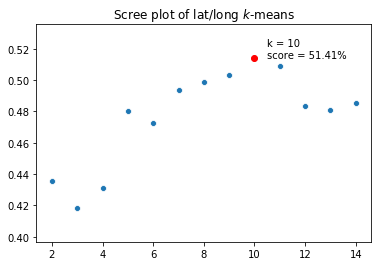

In [51]:
plt.title("Scree plot of lat/long $k$-means")
sns.scatterplot(all_k, scores)
plt.plot(best_k["k"],best_k["score"], "ro")
plt.text(best_k["k"] + .5 ,best_k["score"], "k = {}\nscore = {:.2%}".format(best_k['k'],best_k['score']));

According to the silhouette score, an optimum number of clusters for longitude and latitude occur is 9.

In [52]:
km = KMeans(n_clusters= best_k["k"], random_state = random_state)
km.fit(lat_long_df)
complete_df["location_cluster"] = km.labels_

### Creating "Incomplete" Dataset
As a proof of concept and practical use-case, we're interested in allowing a user to input a NYC zip code and quickly know the affluency of the area. This would allow emergency responders to quickly assess which areas are in the most need. This application is explained in more detail in the [Data Query](#Data-Query) section.

Having an incomplete dataset (which includes observations without affluency) allows us to pass the pertinent information about a zip code through our model to make a prediction for the affluency of the area.

In [60]:
temp_incomplete_df = pd.merge(df_yelp, affluency_df, on = "zip_code", how = 'outer')
temp_incomplete_df[convert_to_int] = temp_incomplete_df[convert_to_int].astype(int)
temp_incomplete_df["price*rating"] = temp_incomplete_df["price"] * temp_incomplete_df["rating"]
temp_incomplete_df["is_affluent"] = (temp_incomplete_df["affluency_rate"] >= affluency_thresh).astype(int)

dummy_incomplete_df = pd.DataFrame(lce.transform(temp_incomplete_df).toarray(), columns=lce.get_feature_names())

incomplete_df = pd.concat([temp_incomplete_df.drop(columns = expansion_columns), dummy_incomplete_df], axis=1)

incomplete_df["location_cluster"] = km.predict(incomplete_df[["latitude","longitude"]])

## Exploratory Data Analysis
- [Mahdi] and [Hadi] killer graphs and visuals

In [ ]:
# SET THRESHOLD FOR NUMBER OF OBSERVATIONS TO SHRINK IMAGE
order_of_cities = complete_df.groupby("city")["affluency_rate"].mean().sort_values().index

In [ ]:
plt.figure(figsize = (6,28))
sns.boxplot(data = complete_df, y = "city", x = "affluency_rate", orient="h", order=order_of_cities);

Here, we see some correlation between `city` and the affluency rate of the city. 

However, using subject knowledge we know _these city designations are inconsistent and ambiguous_. For example, "New York" and "New York City" and "Manhattan" and "new york" and "New york" could be considered synonymous.

__Therefore we will not be includeing `city` in our modeling process.__

# ===========
# MESSY BELOW HERE

### Visualizing location clusters

In [185]:
order_of_clusters = complete_df.groupby("location_cluster")["affluency_rate"].mean().sort_values().index

colors = np.array(['#e6194b', '#3cb44b', '#F7B32B', '#4363d8', '#f58231', '#911eb4', '#bcf60c', '#F45866','#46f0f0', '#f032e6'])

neighborhoods = ["Bronx", "Upper Bkln", "Astoria", "Staten Island", "Upper Mhtn", "Lower Bkln", "Lower Mhtn", "Jamaica", "Flushing", "New Rochelle\n&\nYonkers"]

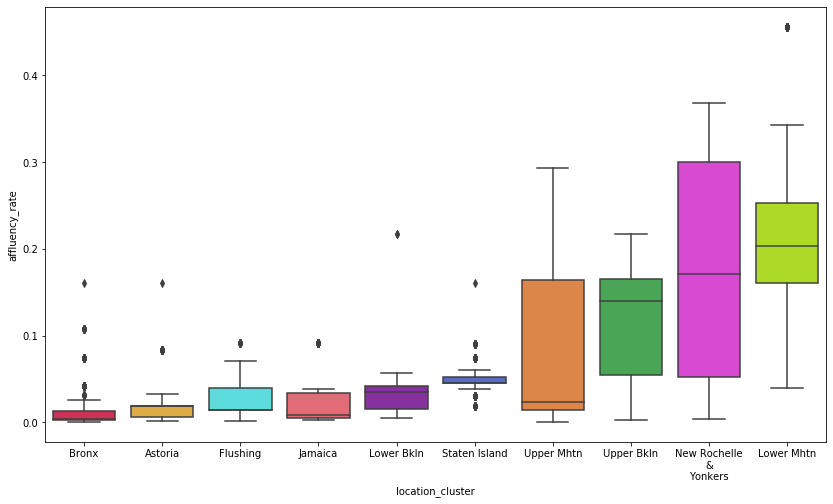

In [186]:
plt.figure(figsize = (14,8))
g = sns.boxplot(
    data = complete_df, 
    x = "location_cluster", 
    y = "affluency_rate", 
    order = order_of_clusters,
    palette = colors[order_of_clusters],
);

g.set(xticklabels = np.array(neighborhoods)[order_of_clusters]);

### Visualizing 

Visualizing affluency by location

In [168]:
# Prepping geograph
lat    = complete_df['latitude'].values
lon    = complete_df['longitude'].values
price  = complete_df['price'].values
rating = complete_df['rating'].values

padding = .05
lat_diff = complete_df["latitude"].max() - complete_df["latitude"].min()
lat_pad = (lat_diff) * padding

lon_diff = complete_df["longitude"].max() - complete_df["longitude"].min()
lon_pad = (lon_diff) * padding

scale = 10

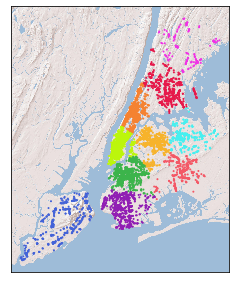

In [188]:
from mpl_toolkits.basemap import Basemap

# https://matplotlib.org/basemap/api/basemap_api.html
# https://matplotlib.org/basemap/users/geography.html
# https://basemaptutorial.readthedocs.io/en/latest/backgrounds.html#arcgisimage
plt.figure(figsize=(lon_diff * scale, lat_diff * scale))
m = Basemap(
    resolution = None, 
    llcrnrlat = complete_df["latitude"].min() - lat_pad,
    llcrnrlon = complete_df["longitude"].min() - lon_pad,
    urcrnrlat = complete_df["latitude"].max() + lat_pad,
    urcrnrlon = complete_df["longitude"].max() + lat_pad,
    epsg = 3395
)
m.arcgisimage(service ="World_Shaded_Relief", xpixels = 2000)
m.scatter(lon, lat, latlon=True, 
    s = 1,
    c = colors[complete_df["location_cluster"]]
);

# ADD COLOR BARS

In [ ]:
from mpl_toolkits.basemap import Basemap

# https://matplotlib.org/basemap/api/basemap_api.html
# https://matplotlib.org/basemap/users/geography.html
# https://basemaptutorial.readthedocs.io/en/latest/backgrounds.html#arcgisimage
plt.figure(figsize=(lon_diff * scale, lat_diff * scale))
m = Basemap(
    resolution = None, 
    llcrnrlat = complete_df["latitude"].min() - lat_pad,
    llcrnrlon = complete_df["longitude"].min() - lon_pad,
    urcrnrlat = complete_df["latitude"].max() + lat_pad,
    urcrnrlon = complete_df["longitude"].max() + lat_pad,
    epsg = 3395
)


m.arcgisimage(service ="World_Shaded_Relief", xpixels = 2000)
m.scatter(lon, lat, latlon=True, 
    s = 1,
    cmap ='cool', 
    c = complete_df["affluency_rate"]
);

# Add colorbar

# MESSY ABOVE HERE
# ===========

## Saving/Loading Clean data

#### Saving cleaned datasets

In [80]:
# complete_df.to_csv("./data/clean_data.csv")
# incomplete_df.to_csv("./data/clean_incomplete_data.csv")

#### Loading cleaned datasets

In [91]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import columnExpander
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [92]:
complete_df = pd.read_csv("./data/clean_data.csv", index_col = 0)
incomplete_df = pd.read_csv("./data/clean_incomplete_data.csv", index_col = 0)

In [93]:
complete_df.head()

,id,price,rating,review_count,zip_code,city,state,latitude,longitude,affluency_rate,...,categories_thai,categories_artmuseums,categories_tobaccoshops,categories_internetcafe,transactions_,transactions_pickup,transactions_restaurant_reservation,transactions_delivery,is_affluent,location_cluster
0,GA5msU6NO9rQRctPfDJCBg,2.0,4,1082,11216,Brooklyn,NY,40.683370,-73.943780,0.022398,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0,1
1,KkAtVVjnMfb1vGlcpzmhgw,2.0,4,303,11216,Brooklyn,NY,40.677866,-73.950000,0.022398,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0,1
2,34LM8_lP8iwizHBu6YgaQQ,2.0,4,200,11216,Brooklyn,NY,40.680160,-73.941975,0.022398,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0,1
3,ipmOYDh9snm3ZUv546MACQ,1.0,4,178,11216,Crown Heights,NY,40.672984,-73.950312,0.022398,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0,1
4,Dv28TvKBh_8i6W02uAaMKw,2.0,4,140,11216,Bedford-Stuyvesant,NY,40.689756,-73.951087,0.022398,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1


## Modeling: Two Paths
With almost 300 features, we were interested in finding an optimal model to determine how significant Yelp prices are in predicting affluency in an area******* (This is different from affluency of individual business)

We considered feature elimination as well as extraction, and decided on splitting the difference. We tried fitting models without altering the data, [PATH 1](#PATH-1:-Default-dataset), as well as trying to fit models with a reduced dataset, [PATH 2](#PATH-2:-Feature-Reduction).

### Establishing baseline model

In [94]:
complete_df["is_affluent"].value_counts(normalize = True)

0    0.704557
1    0.295443
Name: is_affluent, dtype: float64

The baseline accuracy for the data is about 71.7% being not affluent.

**** Being mindful of our metric - accuracy not what we're using

### Defining scorer object

In order to have GridSearchCV properly optimize for our metric, we have to create a sklearn scorer object and provide it as the `scorer` argument.

In [95]:
def spec(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    specificity = (TN)/(TN+FP)
    return specificity

specificity_scorer = make_scorer(spec)

## PATH 1: Default dataset
### Model Preparation

In [96]:
remove_columns = [
    'id',
    'zip_code',
    'city',
    'state',
    'latitude',
    'longitude',
    'affluency_rate',
    'transactions_'
]
target = 'is_affluent'

In [97]:
X = complete_df.drop(columns=remove_columns+[target])
y = complete_df[target]

In [98]:
X.shape

(9809, 289)

### Custom `gridSearchHelper` function
This function simply includes some "quality of life" functionality to help streamline the modeling process, such as printing the training score, test, score and and confusion matrix.

In [99]:
def gridSearchHelper(estimator, params, X, y, standardize = False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, stratify = y)

    if standardize:
        sc      = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test  = sc.transform(X_test)

    gs = GridSearchCV(estimator, params, cv = 5, n_jobs=-1, scoring = specificity_scorer)
    gs.fit(X_train, y_train)
    print("Train score:", gs.best_score_)
    print("Test score:", gs.score(X_test, y_test))
    print("Confusion Matris:\n", confusion_matrix(y_test, gs.predict(X_test)))
    return gs

### Logistic Model

In [100]:
lr_params = {'C': [1.023292992280754],
          'penalty': ['l2']}

gridSearchHelper(LogisticRegression(), lr_params, X, y);

Train score: 0.9071984105121795
Test score: 0.9045138888888888
Confusion Matris:
 [[1563  165]
 [ 427  298]]


- [Eddie] Please comment after each model your observations/opinion. Whenever possible give rational as to why you want to try the next model.

### K-Nearest Neighbors

In [102]:
knn_params = {'n_neighbors': [11],
              'algorithm': ['ball_tree']}

gridSearchHelper(
    KNeighborsClassifier(),
    knn_params, 
    X, y, 
    standardize = True # Must standardize for KNN
);

Train score: 0.8923405665635653
Test score: 0.8819444444444444
Confusion Matris:
 [[1524  204]
 [ 474  251]]


- {Eddie's comments}

### Decision Tree

In [129]:
dt_params = {'max_depth': [3],
             'min_samples_split': [2],
             'min_samples_leaf': [1],
             'max_features': [ None]}

gs_dt = gridSearchHelper(
    DecisionTreeClassifier(random_state = random_state), 
    dt_params, 
    X, y
);

Train score: 0.9257190834045027
Test score: 0.921875
Confusion Matris:
 [[1593  135]
 [ 209  516]]


- {Eddie's comments}

### Bagging

In [113]:
bc_params = {'n_estimators': [30],
             'max_features': [50]}

gridSearchHelper(
    BaggingClassifier(random_state = random_state), 
    bc_params, 
    X, y
);

Train score: 0.9830212501338034
Test score: 0.984375
Confusion Matris:
 [[1701   27]
 [ 624  101]]


- {Eddie's comments}

### XGBoost

In [114]:
boost_params = {'booster': ['gbtree'],
             'max_depth': [3],
             'learning_rate': [.01]}

gridSearchHelper(
    xgb.XGBClassifier(random_state = random_state), 
    boost_params, 
    X, y
);

Train score: 0.9299643993202948
Test score: 0.921875
Confusion Matris:
 [[1593  135]
 [ 209  516]]


- {Eddie's comments}

## PATH 2: Feature Reduction
### Model Preparation

## Model Selection
- [Hadi] Exploring models
- [Eddie] Exploring models

Maybe split on which models you 2 want to try out

We are focusing on reducing false positives as much as possible, so our metric is specificity.

## Model Evaluation
- [Mahdi] killer graphs and visuals

use `interact`  
to make predictive zip code affluency function

## Data Query

Defining a query where we input the zip code and it returns a dataframe with the associated affluency.

- [Eddie] Include more description and use-case example. This is a powerful tool, play it up more!

In [130]:
def query(postal_code):
    if incomplete_df[incomplete_df['zip_code'] == postal_code]['affluency_rate'].isnull().sum() == 0:
        return pd.DataFrame({'zip_code': postal_code, 'affluency_rate': incomplete_df[incomplete_df['zip_code'] == postal_code]['affluency_rate'].iloc[0]}, index = range(1))
    else:
        X = incomplete_df[incomplete_df['zip_code'] == postal_code].drop(columns = ['id',
                                                                            'zip_code',
                                                                            'city',
                                                                            'state',
                                                                            'latitude',
                                                                            'longitude',
                                                                            'affluency_rate',
                                                                            'transactions_'])
        y_pred = gs_dt.predict(X)
        return pd.DataFrame({'zip_code': postal_code, 'affluency_rate': y_pred.mean()}, index= range(1))

In [116]:
query(10001) # zip code with known affluency rate

,zip_code,affluency_rate
0,10001,0.161157


In [135]:
print("Missing zips:",incomplete_df["zip_code"][incomplete_df.affluency_rate.isnull()].unique())

Missing zips: [11249 11239 10020 10169 10281 10455 10459 11430]


In [136]:
query(11249)

ValueError: Number of features of the model must match the input. Model n_features is 289 and input n_features is 290 

## Conclusions and Recommendations
- [All]

## Source Documentation
- [NYC zip codes](https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php)
- [Yelp API - Business Endpoints](https://www.yelp.com/fusion)
- [IRS dataset](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi)

# TO DO 
- Clean up imports
- Organize the Table of Contents